# Exploration of the Pima diabetes dataset

In [34]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

from sklearn.linear_model import LinearRegression

In [35]:
def replace_with_median(df, col_name, nan_value):
    series = df[col_name]
    median = series[series!=nan_value].median()
    df[col_name].replace(nan_value, median, inplace=True)

In [36]:
#loading data from CSV file
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Attributes:

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skin fold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index (weight in kg/(height in m)^2)

DiabetesPedigreeFunction: Diabetes pedigree function

Age: Age (years)

Outcome: Class variable (0 or 1)

## First look at the data

In [37]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


* Some of the columns contain 0 as a minimum value, while this makes sense for # of pregnancies it doesn't make sense for Glucose, BloodPressure, SkinThickness, Insulin and BMI - Those should be treated as missing values and imputed somehow or ignored.

* The dataset seems balanced overall.


### Missing values count

In [38]:
df_sub = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]
missing_val_row_count = (df_sub == 0).astype(int).sum(axis=1)
missing_val_row_count.describe()

count    768.000000
mean       0.848958
std        0.987853
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        4.000000
dtype: float64

Now I will check how many missing values are in each column(parameter).

In [39]:
missing_val_col_count = (df_sub == 0).astype(int).sum(axis=0)
missing_val_col_count

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

# Individual parameter analysis

## Glucose 

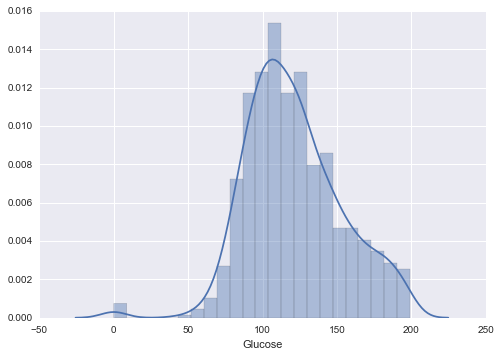

In [40]:
sns.distplot(df.Glucose)

Next, I remove the 0's and replace them with column median. 

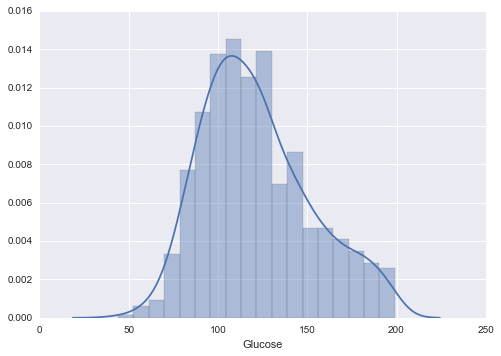

In [41]:
replace_with_median(df, 'Glucose', 0)
sns.distplot(df.Glucose)

- Why is there no Glucose value higher than 200? 

## Blood Pressure

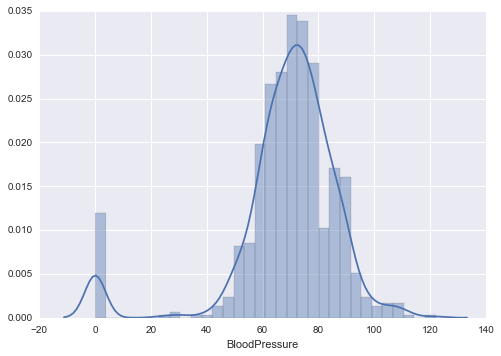

In [42]:
sns.distplot(df.BloodPressure)

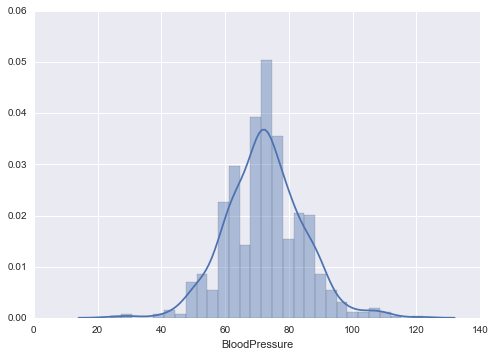

In [43]:
replace_with_median(df, 'BloodPressure', 0)
sns.distplot(df.BloodPressure)

- BloodPressure plot is as expected ([normal diastolic BP](http://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained#Numbers2) is between 60 and 80). 

## BMI

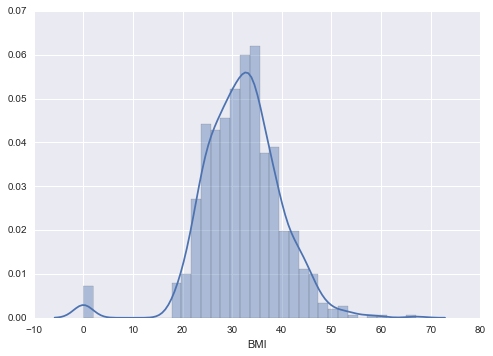

In [44]:
sns.distplot(df.BMI)

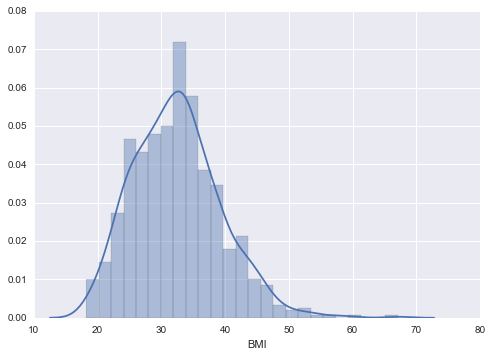

In [45]:
replace_with_median(df, 'BMI', 0)
sns.distplot(df.BMI)

## Skin Thickness

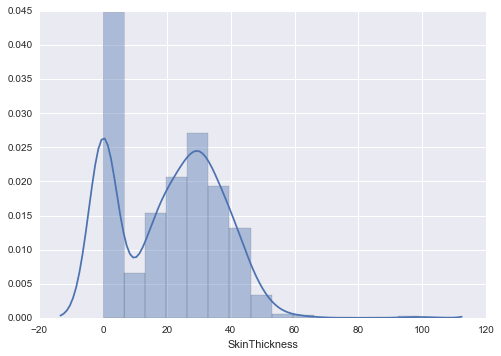

In [46]:
sns.distplot(df.SkinThickness)

The SkinThickness attribute relatively many missing values, therefore replacing it with the median isn't a viable option. I will check for existing correlation between SkinThicness and other parameters.

In [47]:
drop_zeros_df = df[df.Insulin != 0]
drop_zeros_df = df[df.SkinThickness != 0]
drop_zeros_df.corr().SkinThickness.sort_values(ascending = False)

SkinThickness               1.000000
BMI                         0.647978
Outcome                     0.259491
Glucose                     0.227301
BloodPressure               0.226723
Age                         0.166816
Insulin                     0.126423
DiabetesPedigreeFunction    0.115016
Pregnancies                 0.100239
Name: SkinThickness, dtype: float64

The correlation values above suggest that SkinThickness strongly correlates with BMI (corr > 0.5), there are two options:
- Drop SkinThickness altogether. 
- Impute SkinThickness from BMI (using linear regression for example). 

## Insulin

Insulin has an even worse missing value problem than SkinThickness. I will check correlation again. 

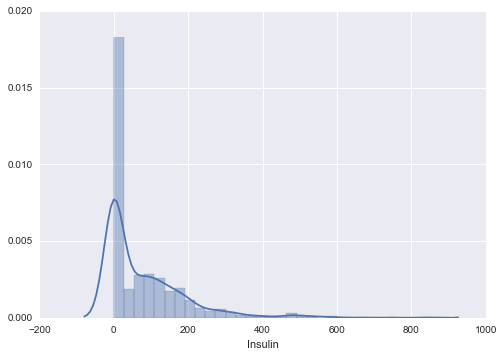

In [48]:
sns.distplot(df.Insulin)

In [49]:
drop_zeros_df.corr().Insulin.sort_values(ascending = False)

Insulin                     1.000000
Glucose                     0.459934
Outcome                     0.207919
BMI                         0.188175
DiabetesPedigreeFunction    0.147961
SkinThickness               0.126423
Age                         0.083271
BloodPressure               0.009369
Pregnancies                -0.006768
Name: Insulin, dtype: float64

The strongest correlation of Insulin is with Glucose. Again there are two options:
- To impute. 
- To drop. 

## Summary

For my first analysis, I will be dropping the columns (parameters) with the most missing values - Insulin and SkinThickness.
It's important to note that both of them have positive correlations with other parameters. 

In [50]:
df.drop(['Insulin', 'SkinThickness'], axis = 1, inplace=True)
df.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


In [51]:
df.to_csv('28-11-16--clean_pima_dataset.csv')

In [53]:
df.corr().Age.sort_values(ascending = False)

Age                         1.000000
Pregnancies                 0.544341
BloodPressure               0.324915
Glucose                     0.266909
Outcome                     0.238356
DiabetesPedigreeFunction    0.033561
BMI                         0.025597
Name: Age, dtype: float64